# カルマンフィルタ

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

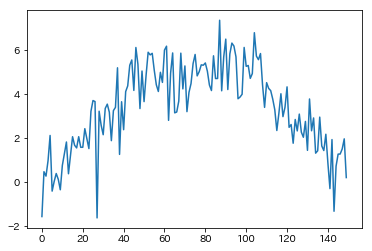

In [2]:
xx = np.concatenate(
    (np.arange(50) * 0.1 + np.random.normal(size=50),
     np.random.normal(loc=5., size=50),
     5 - 0.1 * np.arange(50) + np.random.normal(size=50)), axis=0)
plt.plot(xx)

### 前向きの推定（フィルタリング）

ベイズの定理より、

\begin{eqnarray}
\alpha(\boldsymbol{z}_{n}) = p(\boldsymbol{z}_{n} | \boldsymbol{x}_{1}:\boldsymbol{x}_{n}) &=& \frac{p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}) p(\boldsymbol{z}_{n} | \boldsymbol{x}_{1}:\boldsymbol{x}_{n-1})}{p(\boldsymbol{x}_{n} | \boldsymbol{x}_{1}:\boldsymbol{x}_{n-1})} \\
&=& \frac{p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}) \int p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1})p(\boldsymbol{z}_{n-1} | \boldsymbol{x}_{1}:\boldsymbol{x}_{n-1}) d\boldsymbol{z}_{n-1}}{p(\boldsymbol{x}_{n} | \boldsymbol{x}_{1}:\boldsymbol{x}_{n-1})} \\
&=& \frac{p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}) \int p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1}) \alpha(\boldsymbol{z}_{n-1}) d\boldsymbol{z}_{n-1}}{p(\boldsymbol{x}_{n} | \boldsymbol{x}_{1}:\boldsymbol{x}_{n-1})}
\end{eqnarray} 

という再帰的な式で書け、これを計算すると以下の結果を得る。
\begin{eqnarray}
p(\boldsymbol{z}_{n} | \boldsymbol{x}_{1}:\boldsymbol{x}_{n}) &=& \mathcal{N}(\boldsymbol{z}_{n} | \boldsymbol{\mu}_{n}, V_{n}) \\
\boldsymbol{\mu}_{n} &=& A \boldsymbol{\mu}_{n-1} + K_{n} (\boldsymbol{x}_{n} - CA \boldsymbol{\mu}_{n-1}) \\
V_{n} &=& (I - K_{n} C) P_{n-1} \\
K_{n} &=& P_{n-1}C^{\mathrm{T}} (CP_{n-1}C^{\mathrm{T}} + \Sigma)^{-1} \\
P_{n-1} &=& AV_{n-1}A^{\mathrm{T}} + \Gamma \\
\\
\boldsymbol{\mu}_{1} &=& \boldsymbol{\mu}_{0} + K_{1} (\boldsymbol{x}_{1} - C \boldsymbol{\mu}_{0}) \\
V_{1} &=& (I - K_{1} C) V_{0} \\
K_{1} &=& V_{0}C^{\mathrm{T}} (CV_{0}C^{\mathrm{T}} + \Sigma)^{-1}
\end{eqnarray} 

### 後ろ向きの推定（スムージング）

スムージングでは、$\beta(\boldsymbol{z}_{n})$という量を計算する。
\begin{eqnarray}
\beta(\boldsymbol{z}_{n}) = p(\boldsymbol{x}_{n+1}:\boldsymbol{x}_{N} | \boldsymbol{z}_{n}) &=& \int p(\boldsymbol{x}_{n+2}:\boldsymbol{x}_{N}| \boldsymbol{z}_{n+1}) p(\boldsymbol{x}_{n+1}| \boldsymbol{z}_{n+1}) p(\boldsymbol{z}_{n+1}| \boldsymbol{z}_{n}) d \boldsymbol{z}_{n+1} \\
&=& \int \beta(\boldsymbol{z}_{n+1}) p(\boldsymbol{x}_{n+1}| \boldsymbol{z}_{n+1}) p(\boldsymbol{z}_{n+1}| \boldsymbol{z}_{n}) d \boldsymbol{z}_{n+1}
\end{eqnarray}

### 事後分布

ここで、事後分布は$\gamma(\boldsymbol{z}_{n}) = p(\boldsymbol{z}_{n} | \boldsymbol{x}_{1}:\boldsymbol{x}_{N}) \propto \alpha(\boldsymbol{z}_{n}) \beta(\boldsymbol{z}_{n})$であり計算の結果、以下の平均$\hat{\boldsymbol{\mu}}$, 分散$\hat{V}$をもつガウス分布となる。

\begin{eqnarray}
\hat{\boldsymbol{\mu}}_{n} &=& \boldsymbol{\mu}_{n} + J_{n} (\hat{\boldsymbol{\mu}}_{n+1} - A \boldsymbol{\mu}_{n}) \\
\hat{V}_{n} &=& V_{n} + J_{n} (\hat{V}_{n+1} - P_{n}) J_{n}^{\mathrm{T}} \\
J_{n} &=& V_{n} A^{\mathrm{T}} P_{n}^{-1}
\end{eqnarray} 

## 学習

パラメータを$\boldsymbol{\theta} = [A, \Gamma, C, \Sigma, \boldsymbol{\mu}_{0}, V_{0}]$としEMアルゴリズムによってパラメータを推定する。観測データ$X = [\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, .., \boldsymbol{x}_{N}]$, 潜在変数$Z = [\boldsymbol{z}_{1}, \boldsymbol{z}_{2}, .., \boldsymbol{z}_{N}]$に対して対数尤度関数は以下のようになる。

\begin{eqnarray}
\log{p(X, Z | \boldsymbol{\theta})} &=& \log{[p(\boldsymbol{z}_{1}) \prod_{n=2}^{N} p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1}) \prod_{n=1}^{N} p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n})]} \\
&=& \log{p(\boldsymbol{z}_{1}; \boldsymbol{\mu}_{0}, V_{0})} + \sum_{n=2}^{N} \log{p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1}; C, \Sigma)} + \sum_{n=1}^{N} \log{p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}; A, \Gamma)}
\end{eqnarray}

EMアルゴリズムでは
1. パラメータを初期化する。
2. 現在のパラメータでの事後分布$p(Z, X; \boldsymbol{\theta}^{old})$を計算する。(E step)
3. その分布における期待対数尤度関数$\mathbb{E}_{Z | \boldsymbol{\theta}^{old}} [\log{p(X, Z | \boldsymbol{\theta})}]$を最大化するパラメータ$\boldsymbol{\theta}^{new}$を計算する。(M step)
4. 収束すれば終了し、そうでなければ2へ戻る。

ここでステップ2で計算される事後分布は以下の統計量となる。

\begin{eqnarray}
\mathbb{E} [\boldsymbol{z}_{n}] &=& \hat{\boldsymbol{\mu}}_{n} \\
\mathbb{E} [\boldsymbol{z}_{n} \boldsymbol{z}_{n-1}^{\mathrm{T}}] &=& J_{n-1} \hat{V}_{n} + \hat{\boldsymbol{\mu}}_{n} \hat{\boldsymbol{\mu}}_{n-1}^{\mathrm{T}} \\
\mathbb{E} [\boldsymbol{z}_{n} \boldsymbol{z}_{n}^{\mathrm{T}}] &=& \hat{V}_{n} + \hat{\boldsymbol{\mu}}_{n} \hat{\boldsymbol{\mu}}_{n}^{\mathrm{T}}
\end{eqnarray}

またステップ3で計算される新しいパラメータは以下で更新される。

\begin{eqnarray}
\boldsymbol{\mu}_{0}^{new} &=& \mathbb{E} [\boldsymbol{z}_{1}]\\
V_{0}^{new} &=& \mathbb{E} [\boldsymbol{z}_{1} \boldsymbol{z}_{1}^{\mathrm{T}}] - \mathbb{E} [\boldsymbol{z}_{1}] \mathbb{E} [\boldsymbol{z}_{1}^{\mathrm{T}}] \\
A^{new} &=& (\sum_{n=2}^{N} \mathbb{E} [\boldsymbol{z}_{n} \boldsymbol{z}_{n-1}^{\mathrm{T}}]) (\sum_{n=2}^{N} \mathbb{E} [\boldsymbol{z}_{n-1} \boldsymbol{z}_{n-1}^{\mathrm{T}}])^{-1} \\
\Gamma^{new} &=& \frac{1}{N-1} \sum_{n=2}^{N} \left[ \mathbb{E} [\boldsymbol{z}_{n} \boldsymbol{z}_{n}^{\mathrm{T}}] - A^{new} \mathbb{E} [\boldsymbol{z}_{n-1} \boldsymbol{z}_{n}^{\mathrm{T}}] - \mathbb{E} [\boldsymbol{z}_{n} \boldsymbol{z}_{n-1}^{\mathrm{T}}] A^{new} + A^{new} \mathbb{E} [\boldsymbol{z}_{n-1} \boldsymbol{z}_{n-1}^{\mathrm{T}}] (A^{new})^{\mathrm{T}} \right] \\
C^{new} &=& (\sum_{n=1}^{N} \boldsymbol{x}_{n} \mathbb{E} [\boldsymbol{z}_{n}^{\mathrm{T}}]) (\sum_{n=1}^{N} \mathbb{E} [\boldsymbol{z}_{n} \boldsymbol{z}_{n}^{\mathrm{T}}])^{-1} \\
\Sigma^{new} &=& \frac{1}{N} \sum_{n=1}^{N} \left[ \boldsymbol{x}_{n} \boldsymbol{x}_{n}^{\mathrm{T}} - C^{new} \mathbb{E} [\boldsymbol{z}_{n}] \boldsymbol{x}_{n}^{\mathrm{T}} - \boldsymbol{x}_{n} \mathbb{E} [\boldsymbol{z}_{n}^{\mathrm{T}}] C^{new} + C^{new} \mathbb{E} [\boldsymbol{z}_{n} \boldsymbol{z}_{n}^{\mathrm{T}}] C^{new} \right] 
\end{eqnarray}

In [3]:
x_train = xx
N = len(x_train)

# パラメータ初期値
A = C = 1
mu0 = 0
Sigma = V0 = 10
Gamma = 0.1
theta = np.array([A, Gamma, C, Sigma, mu0, V0])

# 各変数の初期化
mu = np.zeros(N)
V = np.zeros(N)
K = np.zeros(N)
P = np.zeros(N)

mu_hat = np.zeros(N)
V_hat = np.zeros(N)
J = np.zeros(N)

def filtering(x, theta):
    A, Gamma, C, Sigma, mu0, V0 = theta
    K[0] = V0*C / (C*V0*C + Sigma)
    mu[0] = mu0 + K[0] * (x[0] - C*mu0)
    V[0] = (1 - K[0]*C) * V0
    
    for n in range(1, N):
        P[n-1] = A*V[n-1]*A + Gamma
        K[n] = P[n-1]*C / (C*P[n-1]*C + Sigma)
        mu[n] = A*mu[n-1] + K[n] * (x[n] - C*A*mu[n-1])
        V[n] = (1 - K[n]*C) * P[n-1]

def smoothing(theta):
    A = theta[0]
    mu_hat[-1] = mu[-1]
    V_hat[-1] = V[-1]
    for n in reversed(range(N-1)):
        J[n] = V[n] * A / P[n]
        mu_hat[n] = mu[n] + J[n] * (mu_hat[n+1] - A * mu[n])
        V_hat[n] = V[n] + J[n] * (V_hat[n+1] - P[n]) * J[n]

def expectation(x, theta):
    filtering(x, theta)
    smoothing(theta)
    
    e_z = mu_hat
    a_corr = np.roll(J, 1)*V_hat + mu_hat*np.roll(mu_hat, 1)
    var_z = V_hat + mu_hat**2
    expect = (e_z, a_corr, var_z)
    return expect

def maximization(x, expect):
    e_z, a_corr, var_z = expect
    m0 = e_z[0]
    V0 = var_z[0] - e_z[0]**2
    A = a_corr[1:].sum() / var_z[:-1].sum()
    Gamma = np.mean(var_z[1:] - 2*A*a_corr[1:] + A*var_z[:-1]*A)
    C = np.sum(x * e_z) / var_z.sum()
    Sigma = np.mean(x**2 - 2*C*x*e_z + C*var_z*C)
    theta = np.array([A, Gamma, C, Sigma, mu0, V0])
    return theta

max_iter = 1000
for _ in range(max_iter):
    prev_theta = theta.copy()
    expect = expectation(x_train, theta)
    theta = maximization(x_train, expect)
    if np.allclose(np.sum((theta - prev_theta)**2), 0):
        break

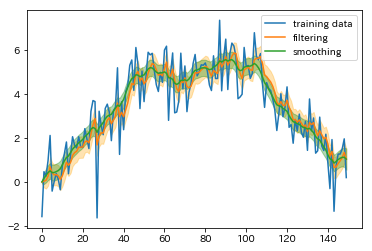

In [4]:
plt.plot(x_train, label='training data')
plt.plot(mu, label='filtering')
plt.fill_between(np.arange(N), mu-np.sqrt(V), mu+np.sqrt(V), color='orange', alpha=0.3)
plt.plot(mu_hat, label='smoothing')
std = np.sqrt(V_hat)
plt.fill_between(np.arange(N), mu_hat-std, mu_hat+std, color='green', alpha=0.3)
plt.legend(loc='upper right')

## スムージングの効果

データが欠損してるところの予測でより有効になる

### 欠損ありデータ

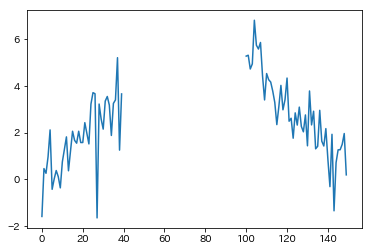

In [5]:
x_train2 = x_train.copy()
x_train2[40:100] = np.nan
plt.plot(x_train2)

In [6]:
# フィルタリングの修正
def filtering(x, theta):
    A, Gamma, C, Sigma, mu0, V0 = theta
    K[0] = V0*C / (C*V0*C + Sigma)
    mu[0] = mu0 + K[0] * (x[0] - C*mu0)
    V[0] = (1 - K[0]*C) * V0
    
    for n in range(1, N):
        P[n-1] = A*V[n-1]*A + Gamma
        K[n] = P[n-1]*C / (C*P[n-1]*C + Sigma)
        # この部分を修正
        if np.isnan(x[n]):
            mu[n] = A * mu[n-1]
            V[n] = P[n-1]
        else:
            mu[n] = A*mu[n-1] + K[n] * (x[n] - C*A*mu[n-1])
            V[n] = (1 - K[n]*C) * P[n-1]

# パラメータを設定
A = 1.
C = 1.
mu0 = 0.
Gamma = 0.01
Sigma = 1.
V0 = 100.
theta = np.array([A, Gamma, C, Sigma, mu0, V0])
filtering(x_train2, theta)
smoothing(theta)

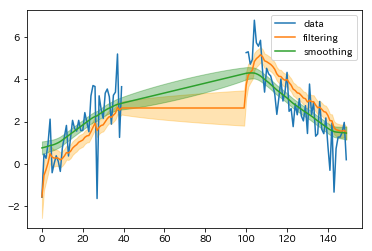

In [7]:
plt.plot(x_train2, label='data')
plt.plot(mu, label='filtering')
std = np.sqrt(V)
plt.fill_between(np.arange(N), mu-std, mu+std, color='orange', alpha=0.3)
std2 = np.sqrt(V_hat)
plt.plot(mu_hat, label='smoothing')
plt.fill_between(np.arange(N), mu_hat-std2, mu_hat+std2, color='green', alpha=0.3)
plt.legend(loc='upper right')